In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from s2sphere import CellId
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [12]:
# Load token stream
data_df = pd.read_csv('data/S2Cell_ID_level16.csv', usecols=[2], names=["S2_Cell_ID"], header=0)
vocab_df = pd.read_csv('data/uniqueS2s_level16.csv', names=["Token"])

data = list(map(int, data_df['S2_Cell_ID'].astype(str).str.strip()))
vocab_tokens = list(map(int, vocab_df['Token'].astype(str).str.strip()))

id_to_idx = {token: idx for idx, token in enumerate(vocab_tokens)}
indexed_data = [id_to_idx[cell_id] for cell_id in data if cell_id in id_to_idx]

data_tensor = torch.tensor(indexed_data, dtype=torch.long)
n = int(0.8 * len(data_tensor))
train_data = data_tensor[:n]
val_data = data_tensor[n:]

print("Data points:", len(indexed_data), "| Vocab size:", len(vocab_tokens))



Data points: 967089 | Vocab size: 103244


In [13]:
def get_batch(data, block_size, batch_size):
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x.to(device), y.to(device)


In [14]:
class SpatialGPT(nn.Module):
    def __init__(self, vocab_size, n_embd=256, n_layer=6, n_head=4, block_size=64):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, n_embd)
        self.pos_embedding = nn.Parameter(torch.zeros(1, block_size, n_embd))
        self.transformer = nn.TransformerDecoder(
            decoder_layer=nn.TransformerDecoderLayer(d_model=n_embd, nhead=n_head, batch_first=True),
            num_layers=n_layer
        )
        self.ln_f = nn.LayerNorm(n_embd)
        self.head = nn.Linear(n_embd, vocab_size)
        self.block_size = block_size

    def forward(self, x):
        B, T = x.size()
        tok_emb = self.token_embedding(x)
        pos_emb = self.pos_embedding[:, :T, :]
        x = tok_emb + pos_emb
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(T).to(x.device)
        x = self.transformer(x, x, tgt_mask=tgt_mask)
        x = self.ln_f(x)
        return self.head(x)


In [15]:
block_size = 64
batch_size = 32
model = SpatialGPT(vocab_size=len(vocab_tokens), block_size=block_size).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

for step in range(25000):
    model.train()
    xb, yb = get_batch(train_data, block_size, batch_size)
    logits = model(xb)
    loss = loss_fn(logits.view(-1, logits.size(-1)), yb.view(-1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if step % 100 == 0:
        print(f"Step {step} | Train Loss: {loss.item():.4f}")


Step 0 | Train Loss: 11.7101
Step 100 | Train Loss: 10.6445
Step 200 | Train Loss: 10.3929
Step 300 | Train Loss: 10.3733
Step 400 | Train Loss: 10.3745
Step 500 | Train Loss: 10.4314
Step 600 | Train Loss: 10.2389
Step 700 | Train Loss: 10.2037
Step 800 | Train Loss: 10.2466
Step 900 | Train Loss: 10.1690
Step 1000 | Train Loss: 10.1697
Step 1100 | Train Loss: 10.2205
Step 1200 | Train Loss: 10.1783
Step 1300 | Train Loss: 10.0898
Step 1400 | Train Loss: 9.9988
Step 1500 | Train Loss: 9.9296
Step 1600 | Train Loss: 10.0248
Step 1700 | Train Loss: 9.8814
Step 1800 | Train Loss: 9.7810
Step 1900 | Train Loss: 9.6866
Step 2000 | Train Loss: 9.8215
Step 2100 | Train Loss: 9.5416
Step 2200 | Train Loss: 9.5681
Step 2300 | Train Loss: 9.6986
Step 2400 | Train Loss: 9.5948
Step 2500 | Train Loss: 9.5107
Step 2600 | Train Loss: 9.3295
Step 2700 | Train Loss: 9.3260
Step 2800 | Train Loss: 9.1939
Step 2900 | Train Loss: 9.2080
Step 3000 | Train Loss: 9.2687
Step 3100 | Train Loss: 9.1710
Step 

In [16]:
def generate(model, context, max_new_tokens):
    model.eval()
    for _ in range(max_new_tokens):
        context_cond = context[:, -block_size:]
        logits = model(context_cond)
        next_token_logits = logits[:, -1, :]
        probs = torch.softmax(next_token_logits, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)
        context = torch.cat((context, next_token), dim=1)
    return context


In [17]:
def s2_to_latlng(s2_id):
    return CellId(s2_id).to_lat_lng()

def decode_and_plot(token_ids):
    s2_ids = [vocab_tokens[token.item()] for token in token_ids[0]]
    coords = [(s2_to_latlng(s2).lat().degrees, s2_to_latlng(s2).lng().degrees) for s2 in s2_ids]
    lats, lngs = zip(*coords)
    plt.scatter(lngs, lats, c='blue')
    plt.title("Generated Spatial Path")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()


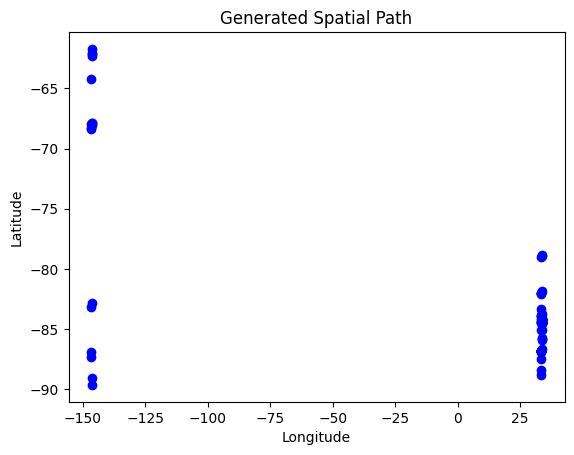

In [18]:
start = torch.randint(0, len(train_data) - block_size, (1,))
seed = train_data[start:start+block_size].unsqueeze(0).to(device)
generated = generate(model, seed, max_new_tokens=20)
decode_and_plot(generated)


In [20]:
def s2_to_latlng(s2_id):
    """Converts S2 Cell ID to (lat, lng) in degrees"""
    latlng = CellId(s2_id).to_lat_lng()
    return latlng.lat().degrees, latlng.lng().degrees

def compare_actual_vs_generated(model, train_data, vocab_tokens, block_size=64, max_new_tokens=20):
    # Sample a random seed from train data
    start = torch.randint(0, len(train_data) - block_size, (1,))
    seed = train_data[start:start+block_size].unsqueeze(0).to(device)

    # Actual continuation from ground truth
    actual = train_data[start+block_size:start+block_size+max_new_tokens]

    # Generated continuation
    model.eval()
    with torch.no_grad():
        context = seed.clone()
        for _ in range(max_new_tokens):
            logits = model(context[:, -block_size:])
            probs = torch.softmax(logits[:, -1, :], dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            context = torch.cat([context, next_token], dim=1)
        generated = context[0, block_size:]  # skip the seed portion

    # Decode both to lat/lng
    actual_ids = [vocab_tokens[t.item()] for t in actual]
    gen_ids = [vocab_tokens[t.item()] for t in generated]

    actual_coords = [s2_to_latlng(s2) for s2 in actual_ids]
    gen_coords = [s2_to_latlng(s2) for s2 in gen_ids]

    # Plot
    plt.figure(figsize=(8, 6))
    if actual_coords:
        lat_actual, lng_actual = zip(*actual_coords)
        plt.plot(lng_actual, lat_actual, marker='o', label='Actual', color='green')
    if gen_coords:
        lat_gen, lng_gen = zip(*gen_coords)
        plt.plot(lng_gen, lat_gen, marker='x', linestyle='--', label='Generated', color='blue')

    plt.legend()
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Actual vs Generated Spatial Path")
    plt.grid(True)
    plt.show()

    # Optional: return the raw values too
    return {
        "actual_tokens": actual.tolist(),
        "generated_tokens": generated.tolist(),
        "actual_coords": actual_coords,
        "generated_coords": gen_coords
    }


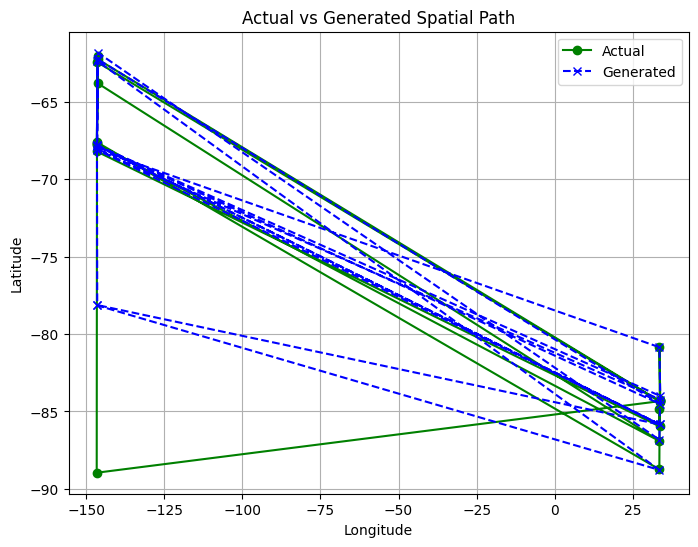

Actual Tokens: [86592, 4321, 23322, 76837, 54160, 20742, 43032, 49776, 12458, 18065, 23322, 16362, 90423, 66955, 97434, 52177, 22356, 50527, 44614, 23271]
Generated Tokens: [86592, 4321, 29842, 8303, 29022, 3890, 11723, 86592, 4321, 46915, 83651, 93206, 95183, 76837, 54160, 39575, 5752, 40700, 5752, 46666]


In [22]:
result = compare_actual_vs_generated(model, train_data, vocab_tokens)

print("Actual Tokens:", result["actual_tokens"])
print("Generated Tokens:", result["generated_tokens"])